## Datasets and DataLoaders in PyTorch

- To decouple data processing code from the model training code, PyTorch provides two data primitives: torch.utils.data.DataLoader and torch.utils.data.Dataset.
- These allow you to use pre-loaded datasets as well as your own data.
- Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples.
- PyTorch domain libraries provide a number of pre-loaded datasets (such as FashionMNIST) that subclass torch.utils.data.Dataset and implement functions specific to the particular data. They can be used to prototype and benchmark your model.

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26.4M/26.4M [00:06<00:00, 4.13MB/s]


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 1.06MB/s]


Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.65MB/s]


Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 5.13MB/s]

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



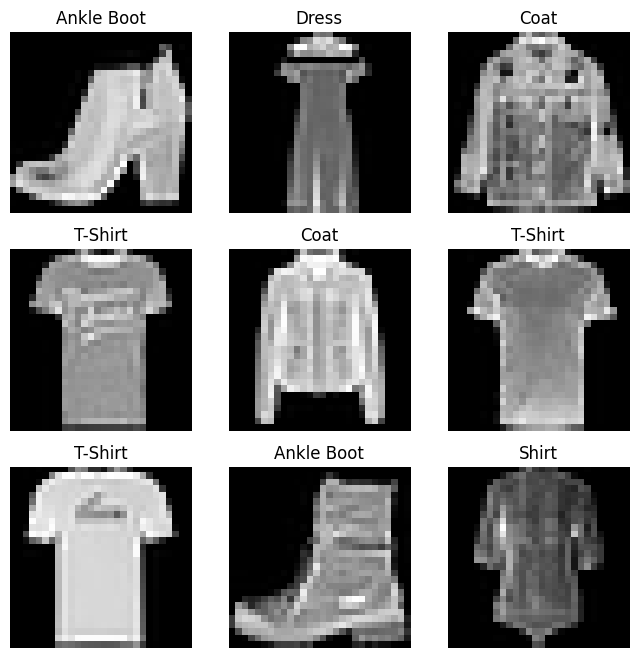

In [2]:
import matplotlib.pyplot as plt
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

You can also create a custom dataset for your files

- A custom Dataset class must implement three functions: init, len, and getitem.

In [3]:
## DataLoader is an iterable that abstracts this complexity for us in an easy API.

from torch.utils.data import DataLoader
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

### Iterate through the DataLoader

Once we load the dataset into the DataLoader, we can iterate through the dataset as needed. Each iteration returns a batch of train_features and train_labels (containing batch_size=64 features and labels respectively). If shuffle=True, after we iterate over all batches, the data is shuffled.

In [4]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


### Transforms
- Transforms are used in PyTorch to perform manipulations on data to transform it into a form that is required for training machine learning algorithms.
- All TorchVision datasets have two parameters — transform to modify the features and target_transform to modify the labels - that accept callables containing the transformation logic. The torchvision.transforms module offers several commonly-used transforms.

- In the code below, we use ToTensor() and Lambda() to transform the FashionMNIST features and corresponding labels. The FashionMNIST features are in PIL Image format, and the labels are integers. For training, we need the features as normalized tensors, and the labels as one-hot encoded tensors. These transformations are made using ToTensor and Lambda. ToTensor converts a PIL image or NumPy ndarray into a FloatTensor, and scales the image's pixel intensity values in the range [0., 1.]

- Lambda transforms apply any user-defined lambda function. Here, we define a function to turn the integer into a one-hot encoded tensor. It first creates a zero tensor of size 10 (the number of labels in our dataset) and calls scatter_ which assigns a value=1 on the index as given by the label y.

In [5]:
from torchvision.transforms import ToTensor, Lambda

ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

## Build up pytorch model


In [6]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


### Define the NeuralNetwork Class to represent your neural network

We define our neural network by subclassing nn.Module, and initialize the neural network layers in init. Every nn.Module subclass implements the operations on input data in the forward method.

In [7]:
from torch import nn

nn.Sequential is an ordered container of modules. The data is passed through all the modules in the same order as defined.

The nn.Flatten layer converts each 2D 28x28 image into a contiguous array of 784 pixel values ( the minibatch dimension (at dim=0) is maintained).

The linear layer is a module that applies a linear transformation on the input using its stored weights and biases.

nn.ReLU Layer: Non-linear activations create the complex mappings between the model’s inputs and outputs. They are applied after linear transformations to introduce nonlinearity, helping neural networks learn a wide variety of phenomena. Non-linear activations like ReLU, SoftMax, Sigmoid, TanH are applied between linear layers in a neural network to introduce non-linearity. Here we use nn.ReLU on the hidden1 layer.

Model Parameters: 
- Layers inside the model have parameters — weights and biases. These parameters are optimized during the model training.

- When you create a model by subclassing the nn.Module, Pytorch automatically tracks all fields defined inside your model object, and makes all parameters accessible using your model’s parameters() or named_parameters() methods.

In [8]:

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [9]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Passing the input data through the model and get the predicted probabilities.

After we create an instance of the model, we pass it input data. This initializes the model and executes the model’s forward operations, along with some background operations. You should not call model.forward() directly.

Calling the model on the input returns a 2-dimensional tensor with dim=0 corresponding to each output of the raw predicted values for each class, and dim=1 corresponding to the individual values of each output.

We get the prediction probabilities by passing it through an instance of the nn.Softmax module.

In [10]:
X = torch.rand(1, 28, 28, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([1])


In [11]:
## we take a sample minibatch of 3 images of size 28x28 from the torch dataset of FashionMNIST and print the image size:
input_image = torch.rand(3,28,28)
print(input_image.size())


torch.Size([3, 28, 28])


In [12]:
flatten = nn.Flatten()
flat_image = flatten(input_image)
print(flat_image.size())

torch.Size([3, 784])


In [13]:
layer1 = nn.Linear(in_features=28*28, out_features=20)
hidden1 = layer1(flat_image)
print(hidden1.size())

torch.Size([3, 20])


In [14]:
print(f"Before ReLU: {hidden1}\n\n")
hidden1 = nn.ReLU()(hidden1)
print(f"After ReLU: {hidden1}")

Before ReLU: tensor([[-0.0596,  0.0796, -0.2315,  0.1933, -0.3839,  0.6995, -0.2612,  0.1835,
          0.1482,  0.0447, -0.5111, -0.0314, -0.9816, -0.5036, -0.5609,  0.0624,
         -0.3071, -0.4158, -0.1008, -0.1150],
        [-0.0598,  0.0239,  0.1319,  0.3473,  0.0788,  0.3962, -0.2413,  0.2170,
          0.1315,  0.3514, -0.3562, -0.2962, -0.5974, -0.1135, -0.1503,  0.1772,
         -0.2540, -0.4160,  0.1720, -0.0084],
        [-0.1264, -0.0827,  0.1613,  0.0748, -0.3461,  0.7100, -0.1327, -0.0901,
          0.0487,  0.3878, -0.4721, -0.4221, -0.9633, -0.2967, -0.2209, -0.2089,
         -0.0381, -0.5185, -0.0670, -0.1023]], grad_fn=<AddmmBackward0>)


After ReLU: tensor([[0.0000, 0.0796, 0.0000, 0.1933, 0.0000, 0.6995, 0.0000, 0.1835, 0.1482,
         0.0447, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0624, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.0000, 0.0239, 0.1319, 0.3473, 0.0788, 0.3962, 0.0000, 0.2170, 0.1315,
         0.3514, 0.0000, 0.0000, 0.0000, 0.0000, 0.00

In [15]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[-0.0108,  0.0153, -0.0099,  ..., -0.0002, -0.0151, -0.0124],
        [-0.0083,  0.0357,  0.0050,  ..., -0.0262, -0.0335, -0.0349]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([0.0056, 0.0106], grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[ 0.0164, -0.0037,  0.0236,  ...,  0.0298,  0.0306, -0.0302],
        [-0.0183, -0.0032,  0.0421,  ...,  0.0350, -0.0330,  0.0137]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.bias | Si

During training, neural networks use back propagation algorithm to adjust the model parameters based on the gradient of the loss function with respect to the given parameter.

To compute those gradients, PyTorch has a built-in differentiation engine called torch.autograd. It supports automatic computation of gradient for any computational graph.

Computational Graph

A computational graph is a graph data structure in which the nodes represent mathematical operators except for one case, where we need to represent creation of a user-defined variable. Creation of a computational graph allows us to easily compute the gradients in a neural network regardless of the architecture type of the neural network.

To demonstrate the computation of gradient, we will create a simplest, one-layer neural network, with input x, parameters w and b, and some loss function.

In this network, w and b are parameters, which we need to optimize. Thus, we need to be able to compute the gradients of loss function with respect to those variables. To do that, we set the requires_grad property of those tensor.

A function that we apply to tensors to construct computational graph is an object of class Function. This object knows how to compute the function in the forward direction, and also how to compute its derivative during the backward propagation step. A reference to the backward propagation function is stored in grad_fn property of a tensor. grad_fn is a function "handle", giving access to the applicable gradient function. The gradient at the given point is a coefficient for adjusting weights during back-propagation.

In [16]:
x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x000001F87149DB40>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x000001F875E33F70>


To compute the derivatives of our loss function with respect to parameters, namely, we need ∂𝑙𝑜𝑠𝑠/∂𝑤 and ∂𝑙𝑜𝑠𝑠/∂𝑏 under some fixed values of x and y, to compute those derivatives, we call loss.backward(), and then retrieve the values from w.grad and b.grad:

We can only obtain the grad properties for the leaf nodes of the computational graph, which have requires_grad property set to True. For all other nodes in our graph, gradients will not be available.
We can only perform gradient calculations using backward once on a given graph, for performance reasons. If we need to do several backward calls on the same graph, we need to pass retain_graph=True to the backward call.

You can diasble gradient tracking:

By default, all tensors with requires_grad=True are tracking their computational history and support gradient computation. However, there are some cases when we do not need to do that, for example, when we have trained the model and just want to apply it to some input data, i.e. we only want to do forward computations through the network.

You might also want to disable gradient tracking to mark some parameters in your neural network as frozen parameters and to speed up computations when you are only doing forward pass, because computations on tensors that do not track gradients would be more efficient.

In [17]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.0027, 0.2776, 0.0252],
        [0.0027, 0.2776, 0.0252],
        [0.0027, 0.2776, 0.0252],
        [0.0027, 0.2776, 0.0252],
        [0.0027, 0.2776, 0.0252]])
tensor([0.0027, 0.2776, 0.0252])


We can stop tracking computations by surrounding our computation code with torch.no_grad() block.

In [18]:
z = torch.matmul(x, w)+b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x, w)+b
print(z.requires_grad)

True
False


Another way to achieve the same result is to use the detach() method on the tensor:

In [19]:
z = torch.matmul(x, w)+b
z_det = z.detach()
print(z_det.requires_grad)

False


PyTorch’s Autograd keeps a record of data (tensors) and all executed operations (along with the resulting new tensors) in a computational graph which is a directed acyclic graph (DAG) consisting of Function objects. In this DAG, leaves are the input tensors, roots are the output tensors. By tracing this graph from roots to leaves, you can automatically compute the gradients using the chain rule. In a forward pass, autograd does two things simultaneously:

run the requested operation to compute a resulting tensor
maintain the operation’s gradient function in the DAG.
The backward pass starts when .backward() is called on the DAG root. autograd then:

computes the gradients from each .grad_fn,
accumulates them in the respective tensor’s .grad attribute
using the chain rule, propagates all the way to the leaf tensors.

### Optimizing Model Parameters

After creating a model and having the data, we will train, validate and test our model by optimizing its parameters on our data.

Training a model is an iterative process; in each iteration the model makes a guess about the output, calculates the error in its guess (loss), collects the derivatives of the error with respect to its parameters (as we saw in the previous section), and optimizes these parameters using gradient descent.

In [24]:
epochs = 10
batch_size = 64
learning_rate = 1e-3

- Optimization Loop

Once we set our hyperparameters, we can then train and optimize our model with an optimization loop. Each iteration of the optimization loop is called an epoch.

Each epoch consists of two main parts:

- The Train Loop — iterate over the training dataset and try to converge to optimal parameters.
- The Validation/Test Loop — iterate over the test dataset to check if model performance is improving.

### Loss Function

When presented with some training data, our untrained network is likely not to give the correct answer. Loss function measures the degree of dissimilarity of obtained result to the target value, and it is the loss function that we want to minimize during training. To calculate the loss we make a prediction using the inputs of our given data sample and compare it against the true data label value.

Common loss functions include nn.MSELoss (Mean Square Error) for regression tasks, and nn.NLLLoss (Negative Log Likelihood) for classification. nn.CrossEntropyLoss combines nn.LogSoftmax and nn.NLLLoss.

In [21]:
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

### Optimizer

Optimization is the process of adjusting model parameters to reduce model error in each training step. Optimization algorithms define how this process is performed. All optimization logic is encapsulated in the optimizer object. Here, we use the SGD optimizer. There are many different optimizers available in PyTorch such as ADAM and RMSProp, that work better for different kinds of models and data.

In [22]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Inside the training loop, optimization happens in three steps:

- Call optimizer.zero_grad() to reset the gradients of model parameters. Gradients by default add up; to prevent double-counting, we explicitly zero them at each iteration.
- Backpropagate the prediction loss with a call to loss.backward(). PyTorch deposits the gradients of the loss w.r.t. each parameter.
- Once we have our gradients, we call optimizer.step() to adjust the parameters by the gradients collected in the backward pass.

In [23]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [25]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)

Epoch 1
-------------------------------
loss: 2.305879  [   64/60000]
loss: 2.301374  [ 6464/60000]
loss: 2.287092  [12864/60000]
loss: 2.282495  [19264/60000]
loss: 2.260978  [25664/60000]
loss: 2.239105  [32064/60000]
loss: 2.236865  [38464/60000]
loss: 2.209741  [44864/60000]
loss: 2.217898  [51264/60000]
loss: 2.173140  [57664/60000]
Test Error: 
 Accuracy: 42.4%, Avg loss: 2.176937 

Epoch 2
-------------------------------
loss: 2.190169  [   64/60000]
loss: 2.169486  [ 6464/60000]
loss: 2.149899  [12864/60000]
loss: 2.140035  [19264/60000]
loss: 2.074665  [25664/60000]
loss: 2.079767  [32064/60000]
loss: 2.075389  [38464/60000]
loss: 2.010519  [44864/60000]
loss: 2.024124  [51264/60000]
loss: 1.966466  [57664/60000]
Test Error: 
 Accuracy: 58.4%, Avg loss: 1.938069 

Epoch 3
-------------------------------
loss: 1.942188  [   64/60000]
loss: 1.911282  [ 6464/60000]
loss: 1.852633  [12864/60000]
loss: 1.784628  [19264/60000]
loss: 1.745510  [25664/60000]
loss: 1.737626  [32064/600

KeyboardInterrupt: 

### Save and Load the Model

PyTorch models store the learned parameters in an internal state dictionary, called state_dict. We can use torch.save method to save these parameters to persistant storage (hard disk).

Saving a model in this way will save the entire module using Python’s pickle module. A common PyTorch convention is to save models using either a .pt or .pth file extension.

You must call model.eval() to set dropout and batch normalization layers to evaluation mode before running inference.

In [ ]:
torch.save(model.state_dict(), PATH)

# Model class must be defined somewhere
model = torch.load(PATH)
model.eval()